# Report01 - 交通事故理赔审核预测

* 姓名 李晨
* 学号 2018202069


## 任务简介

1. 任务类型：
二元分类；预测事故方没有被理赔的概率。

2. 背景介绍：
在交通摩擦（事故）发生后，理赔员会前往现场勘察、采集信息，这些信息往往影响着车主是否能够得到保险公司的理赔。训练集数据包括理赔人员在现场对该事故方采集的36条信息，信息已经被编码，以及该事故方最终是否获得理赔。我们的任务是根据这36条信息预测该事故方没有被理赔的概率。 

3. 数据来源： 
某汽车大数据网站；

4. 数据介绍：
训练集中共有200000条样本，预测集中有80000条样本。

|变量名 | 解释 
:-:| :-
CaseId | 案例编号
Q1 | 理赔员现场勘测采集到的信，Q1代表第一个问题的信息。信息被编码成数字，数字大小没有不代表真实关系
Qk | 同上，Qk代表第k个问题。总共36个问题。  


## 解决途径：
对于二分类的问题，可以使用的算法有很多，这里我们讨论最简单直接的KNN，SVM以及随机森林算法。
* 数据预处理：
首先我们对数据进行简单的处理和读入

In [1]:
# -*- encoding: utf-8 -*-
# Copyright (c) 2019 - BrunoLee <19976561lichen@gmail.com>

import pandas as pd
import os.path as path
import numpy as np

In [2]:
# read data
def readCsvData(fname):
    fname = path.join('data', fname + '.csv')
    table = pd.read_csv(fname, sep=',')
    return table
trainData = readCsvData('train')
testData = readCsvData('test')

参照数据说明，CaseID这列是没有意义的编号，因此这里将他丢弃。

~drop()函数：axis指沿着哪个轴，0为行，1为列；inplace指是否在原数据上直接操作

In [3]:
# 去掉没有意义的一列
trainData.drop("CaseId", axis=1, inplace=True)
#testData.drop("CaseId", axis=1, inplace=True)

### 使用KNN训练模型    
优点是简单，缺点有计算量与数据的大小成正比；对于样本分类不均衡的问题，会产生误判；K值的选择需要经过多次实验进行确定；    
KNN()：
* `n_neighbors` 投票选用最近的K个点进行投票；

将训练数据打乱

In [4]:
from sklearn.utils import shuffle
trainData = shuffle(trainData)
# trainData.head(15)
# 分离标签值
y_train = trainData.pop('Evaluation')
# 划分数据为2:8, 2用于测试K值
slash = int(trainData.shape[0] * 0.8)
trainTrain, y_trainTrain = trainData[:slash], y_train[:slash]
testTrain, y_testTrain = trainData[slash: ], y_train[slash: ]

In [5]:
#训练KNN模型
from sklearn import neighbors
from sklearn.metrics import average_precision_score
import sklearn

testCaseNum = testTrain.shape[0]
# 对于给定的近邻 K 值，计算其在分配的测试集上的效果
def testNeighborNum(neighborNum):
    #start = time.time()
    knn = neighbors.KNeighborsClassifier(n_neighbors=neighborNum, n_jobs=-1)
    knn.fit(trainTrain, y_trainTrain)

    output = knn.predict(testTrain)
    #testTime = time.time() - start
    #print(output)
    # 定义判定标准为平均的正确率
    accuracy = 1 - np.sum(output ^ y_testTrain) / testCaseNum
    #TrainTime = time.time() - start
    avpr = average_precision_score(y_testTrain, output)  
    #print(f'KNN Train time = {TrainTime:.2f}s')
    return [neighborNum,avpr,accuracy]

选取不同的K值进行实验，并画出K值与预测准确率的关系

In [6]:
total, step = 500, 25
result=[]
for k in range(1, total+1,step):
    result.append(testNeighborNum(k))
#result = np.array(result)

Text(0, 0.5, 'AUC')

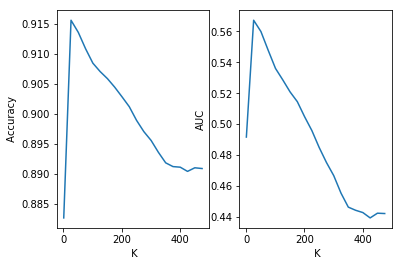

In [14]:
from matplotlib.pyplot import *
result = np.array(result)
figure(1)
ax1 = subplot(121)
plot(result[:,0],result[:,2])
#title(r"$sin^2(x - 2) e^{-x^2}$")
xlabel(' K')
ylabel(' Accuracy ')
ax2 = subplot(122)
plot(result[:,0],result[:,1])
#title(r"$sin^2(x - 2) e^{-x^2}$")
xlabel(' K')
ylabel('AUC')

由以上的验证结果可知

- 当 $K < 200$ 时, 预测的结果均能维持正确率在 **90%** 以上，且总的训练时间加测试时间 **15s** 左右
- 当 $K > 200$ 时，预测结果低于90%，且总的训练时间加测试时间 **20s**以内。

---

在之后的测试环节，选择 $K = 35$ 进行测试

In [8]:
# 定义并训练分类器
K = 35
knn = neighbors.KNeighborsClassifier(n_neighbors=K, n_jobs=-1)
knn.fit(trainData, y_train)

caseIds =  testData.pop('CaseId')

In [9]:
# 提交的是Evaluation为1的概率，故使用predict_proba进行预测

outputs = knn.predict_proba(testData)
submitFile = path.join('data', 'submit_prob.csv')
with open(submitFile, 'w+') as f:
    print('CaseId', 'Evaluation', sep=',', file=f)
    for caseId, output in zip(caseIds, outputs):
        print(caseId, output[1], sep=',', file=f)

0.818832

2. 使用随机森林训练模型    
随机森林是一个包含多个决策树的分类器，输出的类型由输出的类别的众数而定。

In [10]:
from sklearn.ensemble import RandomForestClassifier
# 建立随机森林模型
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(trainData, y_train)
# 预测
y_preds = clf.predict_proba(testData)

输出预测结果到submit_data.csv

In [11]:
# 保存预测的结果
submitFile = path.join('data', 'submit_probRf.csv')
with open(submitFile, 'w+') as f:
    print('CaseId', 'Evaluation', sep=',', file=f)
    for caseId, y_pred in zip(caseIds, y_preds):
        print(caseId, y_pred[1], sep=',', file=f)

In [12]:
#print(output) 

## 总结
这次报告任务是实现对交通事故理赔概率的预测，是一个简单的二分类问题。报告中我们使用了KNN近邻算法以及随机森林算法。其中KNN算法的准确率为81.88%，随机森林算法的准确率为85.12%。在二分类算法中，使用有监督算法和无监督算法也有较大的准确率差异，Kmeans等聚类算法的准确率不如有监督的KNN算法，KNN算法比不上包含多个决策树的的随机森林算法。由于KNN算法原理上的原因，K值的选取对准确率有很大的影响，需要设置一个合适的K值。